<a href="https://colab.research.google.com/github/kieranpatel03/Number-image-generator/blob/main/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras 
from tensorflow.keras import backend 
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
class GAN(keras.Model):
    def __init__(self):
        super().__init__()
        self.disc_optimizer = keras.optimizers.Adam(learning_rate=0.00001) 
        self.gen_optimizer = keras.optimizers.Adam(learning_rate=0.00001) 
        self.rec_optimizer = keras.optimizers.Adam(learning_rate=0.00001) 
        self.generator = keras.Sequential(
            [   
                keras.layers.Dense(256, input_dim=32, activation='relu'),
                keras.layers.Dense(784, activation='sigmoid'),
                keras.layers.Reshape((28, 28)),
            ]
        ) 
        self.discriminator = keras.Sequential(
            [   
                keras.layers.Dense(256, input_dim=816, activation='relu'),
                keras.layers.Dense(1, activation='sigmoid'),
            ]
        )
        self.reconstructor = keras.Sequential(
            [   
                keras.layers.Flatten(input_shape=(28, 28)),
                keras.layers.Dense(256, activation='relu'),
                keras.layers.Dense(32),
            ]
        )


    def train_step(self, data):
      data_len = backend.int_shape(data)[0] #Get training size.
      random_vec = tf.random.normal(shape=(data_len, 32)) #Get the same number of random vectors as the training size. The random vectors will have the same distribution as a normal distribution. 
      sample_images = self.generator(random_vec) #Generate sample images from the random vectors.
      reconstructed_vec = self.reconstructor(data) #Get random vectors from the sample images. 
      with tf.GradientTape() as d_tape:
          real = self.discriminator(tf.concat([tf.reshape(data, (data_len, 784)), reconstructed_vec], axis=1), training=True)
          fake = self.discriminator(tf.concat([tf.reshape(sample_images, (data_len, 784)), random_vec], axis=1), training=True)
          fake_or_real = tf.concat([real, fake], axis=0)
          y_values = tf.concat([tf.ones_like(real), tf.zeros_like(fake)], axis=0)
          disc_loss = keras.losses.binary_crossentropy(y_values, fake_or_real)
          #The loss here is trying to make the discriminator ouput 1 if the image was from the sample data and 0 if the image was generated using the generator.
      with tf.GradientTape() as g_tape:
          sample_images = self.generator(random_vec, training=True)
          fake = self.discriminator(tf.concat([tf.reshape(sample_images, (data_len, 784)), random_vec], axis=1))
          reconstructed_vec = self.reconstructor(sample_images)
          g_loss = keras.metrics.mean_squared_error(reconstructed_vec, random_vec) + keras.losses.binary_crossentropy(tf.ones_like(fake), fake)
          #The loss here is trying to minimize the difference between the reconstructed vector (the vector that has been produced by passing the generated image into the reconstructor network) and the initial random vector. It is also trying to make the discriminator ouput 1 for all images generated using the generator.
      with tf.GradientTape() as r_tape:
          reconstructed_vec = self.reconstructor(sample_images, training=True)
          r_loss = keras.metrics.mean_squared_error(reconstructed_vec, random_vec) 
          #The loss here is trying to minimize the difference between the reconstructed vector and the initial random vector.
      d_gradients = d_tape.gradient(disc_loss, self.discriminator.trainable_variables)
      self.disc_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))
      g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
      self.gen_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
      r_gradients = r_tape.gradient(r_loss, self.reconstructor.trainable_variables)
      self.rec_optimizer.apply_gradients(zip(r_gradients, self.reconstructor.trainable_variables))
      y_true = tf.concat([tf.reshape(sample_images, (data_len, 784)), random_vec], axis=1)
      y_pred = tf.concat([tf.reshape(data, (data_len, 784)), reconstructed_vec], axis=1)
      overall_loss = keras.metrics.kl_divergence(y_true, y_pred) + keras.metrics.mean_squared_error(reconstructed_vec, random_vec) 
      return {"generator_loss": g_loss, 'discriminator_loss': disc_loss, 'reconstructor_loss': r_loss, 'overall_loss': overall_loss}

# class GAN_Callback(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         random_vec = tf.random.normal(shape=(5, 32))
#         data = self.model.generator(random_vec, training=False)
#         data = tf.reshape(data*255, (5, 28, 28))
#         data = data.numpy()
#         for i in range(5):
#           image = Image.fromarray(data[i])
#           if image.mode != 'RGB':
#             image = image.convert('RGB')
#           image.save(f"/content/drive/MyDrive/created_images/EPOCH_{epoch+1}_{i+1}.jpg")

        

In [3]:
(og_x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


11490434/11490434 [==============================] - 0s 0us/step


In [4]:
shape = (og_x_train[0].shape, 1)

x_train = og_x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

ModelGen = GAN()

batch_size = 128

ModelGen.compile()

num_values = len(x_train)%batch_size
x_train = x_train[:-num_values]

ModelGen.fit(x_train, batch_size=batch_size, epochs=50)
# ModelGen.fit(x_train, batch_size=batch_size, epochs=50, callbacks=[GAN_Callback()])

Epoch 1/50
468/468 [==============================] - 7s 8ms/step - generator_loss: 3.0799 - discriminator_loss: 0.3170 - reconstructor_loss: 1.0255 - overall_loss: 4923.5332
Epoch 2/50
468/468 [==============================] - 4s 8ms/step - generator_loss: 4.4712 - discriminator_loss: 0.0691 - reconstructor_loss: 0.9589 - overall_loss: 4598.9551
Epoch 3/50
468/468 [==============================] - 3s 7ms/step - generator_loss: 5.2046 - discriminator_loss: 0.0352 - reconstructor_loss: 0.9295 - overall_loss: 4131.1475
Epoch 4/50
468/468 [==============================] - 3s 7ms/step - generator_loss: 5.7040 - discriminator_loss: 0.0253 - reconstructor_loss: 0.9067 - overall_loss: 3594.9373
Epoch 5/50
468/468 [==============================] - 3s 7ms/step - generator_loss: 6.1131 - discriminator_loss: 0.0221 - reconstructor_loss: 0.8846 - overall_loss: 3075.7280
Epoch 6/50
468/468 [==============================] - 4s 8ms/step - generator_loss: 6.3563 - discriminator_loss: 0.0250 - rec

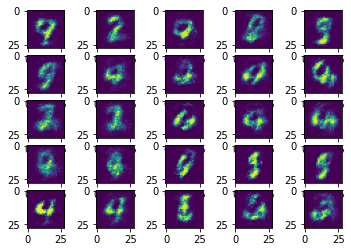

In [5]:
data = ModelGen.generator(tf.random.normal(shape=(25, 32)), training=False)
fig = plt.figure()
for i in range(1, 26):
    fig.add_subplot(5, 5, i)
    plt.imshow(tf.reshape(data[i-1]*255, (28, 28)))
plt.show()